# Feature Selection

In [1]:
# Standard Library Imports
import numpy as np
import pandas as pd

# Third-Party Imports
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Configuration Settings
pd.options.display.max_columns = 50


### Load Data

In [28]:
df = pd.read_csv('/Users/briantreftz/GitHubRepos/Data/ProcessedData/DF_from_EDA_for_Feature_Selection.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6777978 entries, 0 to 6777977
Data columns (total 12 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   Carrier_Name              object
 1   Month                     object
 2   Week_Day                  object
 3   Origin                    object
 4   Destination               object
 5   Dep_Time_Block_Group      object
 6   Arr_Time_Block_Group      object
 7   Distance_Group            int64 
 8   Distance_Miles            int64 
 9   Scheduled_Departure_Time  int64 
 10  Scheduled_Arrival_Time    int64 
 11  Delayed                   int64 
dtypes: int64(5), object(7)
memory usage: 620.5+ MB


,Carrier_Name,Month,Week_Day,Origin,Destination,Dep_Time_Block_Group,Arr_Time_Block_Group,Distance_Group,Distance_Miles,Scheduled_Departure_Time,Scheduled_Arrival_Time,Delayed
0,United Air Lines Inc.,Jan,Friday,IAH,IND,Early Afternoon,Afternoon,4,844,1225,1539,1
1,Southwest Airlines Co.,Jan,Tuesday,MDW,CVG,Morning,Morning,1,249,845,1055,0
2,Southwest Airlines Co.,Jan,Tuesday,MDW,CVG,Early Afternoon,Afternoon,1,249,1340,1550,0
3,Southwest Airlines Co.,Jan,Tuesday,MDW,COS,Early Afternoon,Afternoon,4,917,1330,1510,0
4,Southwest Airlines Co.,Jan,Tuesday,MDW,CMH,Morning,Morning,2,283,840,1050,0


### Down Sampling Data to Address Imbalance in Target Variable

In [29]:
# Separate majority and minority classes
df_majority = df[df.Delayed == 0]
df_minority = df[df.Delayed == 1]

# Downsample majority class to match minority class size
df_majority_downsampled = resample(df_majority,
                                    replace=False,  # Sample without replacement
                                    n_samples=len(df_minority),  # Match minority class size
                                    random_state=1)  # Ensure reproducibility

# Combine minority class with downsampled majority class
df_ds = pd.concat([df_minority, df_majority_downsampled])

# Shuffle the resulting dataframe
df_ds = df_ds.sample(frac=1, random_state=1).reset_index(drop=True)

# Verify the new class distribution
print(df_ds['Delayed'].value_counts())

# Verify new dataframe shape
print(df_ds.shape)

0    1371451
1    1371451
Name: Delayed, dtype: int64
(2742902, 12)


### Determining Categorical Variable Cardinality

In [30]:
cat_vars = [
            'Carrier_Name',
            'Month',
            'Week_Day',
            'Origin',
            'Destination',
            'Dep_Time_Block_Group',
            'Arr_Time_Block_Group'
]

In [31]:
df_ds[cat_vars].nunique()

Carrier_Name             15
Month                    12
Week_Day                  7
Origin                  348
Destination             348
Dep_Time_Block_Group      6
Arr_Time_Block_Group      6
dtype: int64

## Correlation Analysis of Categorical Features to Target

                               Chi2  p-value  Cramér's V
Carrier_Name           54468.535353      0.0    0.140918
Month                  54870.572280      0.0    0.141438
Week_Day                9367.528058      0.0    0.058440
Origin                 38346.692868      0.0    0.118238
Destination            26988.070565      0.0    0.099193
Dep_Time_Block_Group  113784.449054      0.0    0.203674
Arr_Time_Block_Group   98191.996006      0.0    0.189205


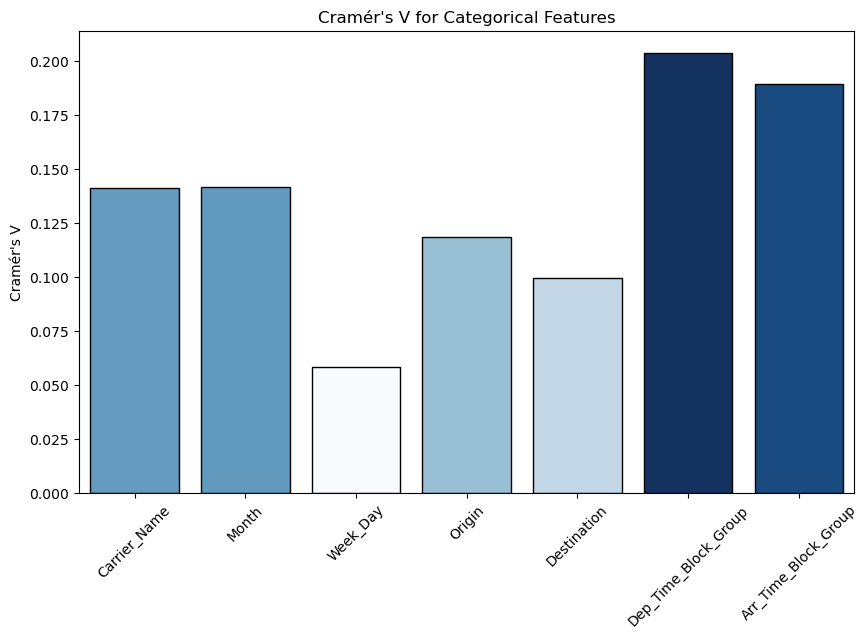

In [32]:
# Target variable
target = 'Delayed'

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Dictionary to store results
results = {}

# Chi-square test and Cramér's V calculation
for feature in categorical_features:
    # Create a contingency table
    contingency_table = pd.crosstab(df_ds[feature], df_ds[target])

    # Perform Chi-square test
    chi2, p, dof, ex = chi2_contingency(contingency_table)

    # Calculate Cramer's V
    cramers_v_value = cramers_v(contingency_table.values)

    # Store results
    results[feature] = {'Chi2': chi2, 'p-value': p, 'Cramér\'s V': cramers_v_value}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Display results
print(results_df)

# Create a monochromatic color palette based on Cramer's V values
max_v = results_df['Cramér\'s V'].max()
min_v = results_df['Cramér\'s V'].min()

# Normalize the Cramer's V scores to [0, 1]
norm = plt.Normalize(min_v, max_v)
cmap = plt.cm.get_cmap('Blues')

# Generate color values based on normalized Cramer's V scores
colors = [cmap(norm(val)) for val in results_df['Cramér\'s V']]

# Plot the Cramér's V values
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=results_df.index, y='Cramér\'s V', data=results_df, palette=colors)

# Enhance bar color visibility
for bar in bars.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

plt.xticks(rotation=45)
plt.title('Cramér\'s V for Categorical Features')
plt.show()

## Correlation Analysis of Numerical Features to Target

                          Pearson Correlation
Scheduled_Arrival_Time               0.155366
Scheduled_Departure_Time             0.198203
Distance_Miles                       0.040265


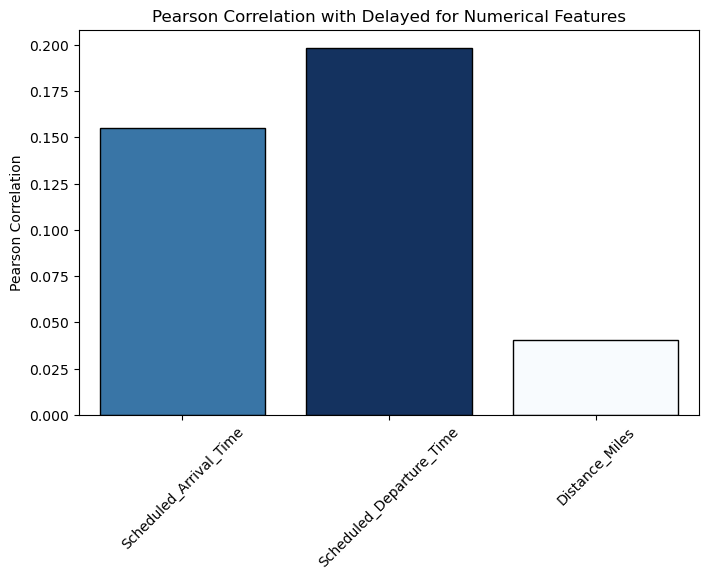

In [33]:
# Function to calculate Pearson correlation
def pearson_correlation(x, y):
    correlation, _ = stats.pearsonr(x, y)
    return correlation

# List of numerical features
numerical_features = ['Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Distance_Miles']

# Dictionary to store results
results_numerical = {}

# Calculate Pearson correlation and store results
for feature in numerical_features:
    correlation = pearson_correlation(df_ds[feature], df_ds[target])
    results_numerical[feature] = {'Pearson Correlation': correlation}

# Convert results to DataFrame
results_numerical_df = pd.DataFrame(results_numerical).T

# Display results for numerical features
print(results_numerical_df)

# Create a monochromatic color palette based on Pearson correlation values
max_corr = results_numerical_df['Pearson Correlation'].max()
min_corr = results_numerical_df['Pearson Correlation'].min()

# Normalize the Pearson correlation scores to [0, 1]
norm = plt.Normalize(min_corr, max_corr)
cmap = plt.cm.get_cmap('Blues')

# Generate color values based on normalized Pearson correlation scores
colors = [cmap(norm(val)) for val in results_numerical_df['Pearson Correlation']]

# Plot the Pearson correlation values
plt.figure(figsize=(8, 5))
bars = sns.barplot(x=results_numerical_df.index, y='Pearson Correlation', data=results_numerical_df, palette=colors)

# Enhance bar color visibility
for bar in bars.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

plt.xticks(rotation=45)
plt.title('Pearson Correlation with Delayed for Numerical Features')
plt.show()


## Evaluating Feature Importance

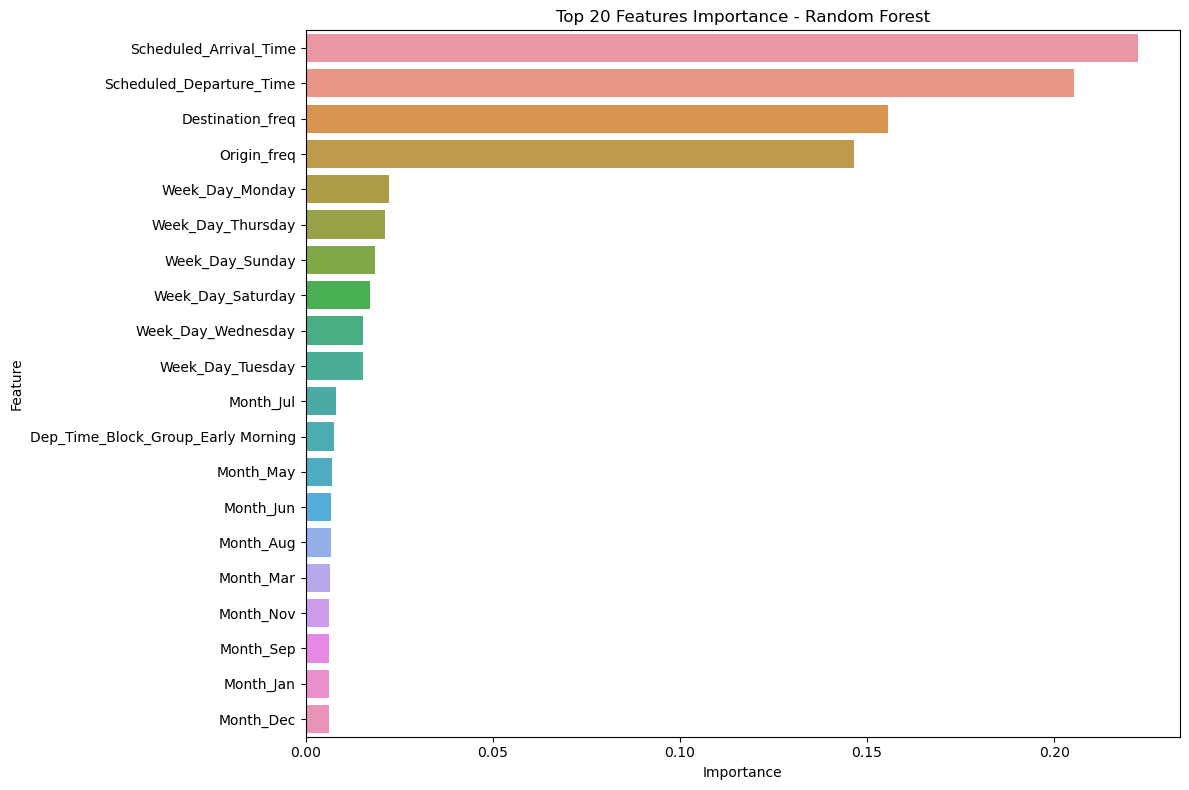

In [23]:
# Encode categorical variables and prepare features
df_encoded = pd.get_dummies(df_ds[['Carrier_Name', 'Month', 'Week_Day', 'Dep_Time_Block_Group', 'Arr_Time_Block_Group']], drop_first=True)
for col in ['Origin', 'Destination']:
    freq_encoding = df_ds[col].value_counts().to_dict()
    df_encoded[col + '_freq'] = df_ds[col].map(freq_encoding)

# Include numerical variables
df_encoded = pd.concat([df_encoded, df_ds[['Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Delayed']]], axis=1)

# Separate features and target variable
X = df_encoded.drop('Delayed', axis=1)
y = df_encoded['Delayed']

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Create DataFrame to store feature importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))  
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features Importance - Random Forest')
plt.tight_layout()
plt.show()

## Export Down Sampled DF for Model Selection

In [36]:
print(df_ds.shape)
df_ds.info()

(2742902, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742902 entries, 0 to 2742901
Data columns (total 12 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   Carrier_Name              object
 1   Month                     object
 2   Week_Day                  object
 3   Origin                    object
 4   Destination               object
 5   Dep_Time_Block_Group      object
 6   Arr_Time_Block_Group      object
 7   Distance_Group            int64 
 8   Distance_Miles            int64 
 9   Scheduled_Departure_Time  int64 
 10  Scheduled_Arrival_Time    int64 
 11  Delayed                   int64 
dtypes: int64(5), object(7)
memory usage: 251.1+ MB


In [37]:
df_ds.to_csv('../../Data/ProcessedData/DF_from_Feature_Sel_for_Model_Sel.csv', index=False)